In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


# 1. Data Inspection

In [4]:
current_dt = datetime(2025, 4, 21, 16, 34, 0)
expiration_dt = datetime(2025, 5, 16, 10, 0, 0)

dir_path = "raw_data/Bloomberg/"
price_file = dir_path + "spx_price_160525_1634.xlsx"
greeks_file = dir_path + "spx_greeks_160525_1634.xlsx"

display(pd.read_excel(price_file, engine='openpyxl', nrows=5).head())
display(pd.read_excel(greeks_file, engine='openpyxl', nrows=5).head())

,Calls,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31
0,Ticker,Strike,Mny,Ask,Bid,IVA,IVM,IVB,Last,DyEx,...,IVM,IVB,Last,DyEx,Volm,Volm 1,OInt,tIVM,tPxM,Pty
1,ERROR(6),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SPX 5/16/25 C200,200,3.877322,4955.399902,4937.299805,556.907235,0,0,5437.060059,24.725648,...,340.73802,0,0.05,24.725648,0,0,258,146.392515,0,0
3,SPX 5/16/25 C400,400,7.754644,4755.800781,4736.699219,426.730499,297.618805,0,0,24.725648,...,265.538898,0,0.05,24.725648,0,0,85,134.549966,0,0
4,SPX 5/16/25 C600,600,11.631966,4556.5,4537.398438,358.015289,268.053345,0,4869.299805,24.725648,...,222.734082,0,0.1,24.725648,0,0,3018,127.112073,0,0


,Calls,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33
0,Ticker,Strike,Rate,DvYd,Last,DL,GL,TL,VL,DM,...,TL,VL,DM,GM,TM,VM,RM,IVal,True,YLst
1,16-May-25 (25d); CSize 100; ; IDiv 1.05; R 4.5...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SPX 5/16/25 C200,200,4.549176,1.846127,5437.060059,1,0,0,0,1,...,-0.0122,0.002272,-0.000037,0.000002,-0.013585,0.002164,-0.000002,0,0,0.05
3,SPX 5/16/25 C400,400,4.549176,1.846127,0,0,0,0,0,1,...,-0.014053,0.002726,-0.000049,0.000003,-0.013875,0.002836,-0.000002,0,0,0.05
4,SPX 5/16/25 C600,600,4.549176,1.846127,4869.299805,1,0,0,0,1,...,-0.025774,0.00598,-0.000059,0.000004,-0.013975,0.003405,-0.000002,0,0,0.1


# 2. Data Preprocessing

In [119]:
import pandas as pd
import numpy as np
from typing import Tuple, Dict


def process_non_numeric(df: pd.DataFrame) -> None:
    """Strips whitespace from 'ticker' column."""
    if 'ticker' in df.columns:
        df['ticker'] = df['ticker'].astype(str).str.strip()


def process_price_numeric(df: pd.DataFrame, base_cols: list) -> None:
    """Processes numeric columns in the price dataframe."""
    numeric_cols = [col for col in base_cols if col != 'ticker']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    df['mid'] = (df['ask'] + df['bid']) / 2
    df['M'] /= 100
    df['T'] = df['days_ex'] / 365
    df['S'] = round(df['K'] / df['M'], 2)

    for iv_col in ['iv_ask', 'iv_mid', 'iv_bid', 'theo_iv']:
        if iv_col in df.columns:
            df[iv_col] /= 100

    df[numeric_cols] = df[numeric_cols].replace(0, np.nan)


def process_greeks_numeric(df: pd.DataFrame, base_cols: list) -> None:
    """Processes numeric columns in the greeks dataframe."""
    numeric_cols = [col for col in base_cols if col != 'ticker']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    for col in ['r', 'q']:
        if col in df.columns:
            df[col] /= 100

    df[numeric_cols] = df[numeric_cols].replace(0, np.nan)


def split_and_process_df(df_raw: pd.DataFrame, base_cols: list, process_numeric_func, tickers: Tuple[str]) -> Dict[str, pd.DataFrame]:
    """Splits the dataframe into call/put and processes them."""
    df_valid = df_raw[df_raw.iloc[:, 0].astype(str).str.startswith(tickers)].copy()
    all_cols = [f"{col}_call" for col in base_cols] + [f"{col}_put" for col in base_cols]
    df_valid.columns = all_cols

    df_call = df_valid[[f"{col}_call" for col in base_cols]].copy()
    df_put = df_valid[[f"{col}_put" for col in base_cols]].copy()
    df_call.columns = df_put.columns = base_cols

    process_non_numeric(df_call)
    process_numeric_func(df_call, base_cols)
    process_non_numeric(df_put)
    process_numeric_func(df_put, base_cols)

    return {'call': df_call, 'put': df_put}


def clean_price_df(path: str, tickers: Tuple[str] = ('SPX', 'SPXW')) -> Dict[str, pd.DataFrame]:
    base_cols = [
        'ticker', 'K', 'M', 'ask', 'bid', 'iv_ask', 'iv_mid', 'iv_bid',
        'last_price', 'days_ex', 'volume', 'volume_1d', 'open_interest',
        'theo_iv', 'theo_price', 'parity'
    ]
    df_raw = pd.read_excel(path, engine='openpyxl', header=None)
    return split_and_process_df(df_raw, base_cols, process_price_numeric, tickers)


def clean_greeks_df(path: str, tickers: Tuple[str] = ('SPX', 'SPXW')) -> Dict[str, pd.DataFrame]:
    base_cols = [
        'ticker', 'K', 'r', 'q', 'last_price', 'delta_last', 'gamma_last',
        'theta_last', 'vega_last', 'delta_mid', 'gamma_mid', 'theta_mid',
        'vega_mid', 'rho_mid', 'ival', 'true', 'ylast'
    ]
    df_raw = pd.read_excel(path, engine='openpyxl', header=None)
    return split_and_process_df(df_raw, base_cols, process_greeks_numeric, tickers)


def reorder_columns(df: pd.DataFrame, order: list) -> pd.DataFrame:
    """Reorders columns by priority list, appending any extras at the end."""
    existing_cols = [col for col in order if col in df.columns]
    remaining_cols = [col for col in df.columns if col not in existing_cols]
    return df[existing_cols + remaining_cols]


def concat_dfs(price_file_path: str, greeks_file_path: str, tickers: Tuple[str] = ('SPX', 'SPXW')) -> Dict[str, pd.DataFrame]:
    """Combines cleaned price and greek data into single DataFrames by call/put and reorders columns."""
    price_dfs = clean_price_df(price_file_path, tickers)
    greeks_dfs = clean_greeks_df(greeks_file_path, tickers)

    call_df = pd.concat([
        price_dfs['call'].set_index('ticker'),
        greeks_dfs['call'].set_index('ticker').drop(columns=['K', 'last_price'], errors='ignore')
    ], axis=1).reset_index()

    put_df = pd.concat([
        price_dfs['put'].set_index('ticker'),
        greeks_dfs['put'].set_index('ticker').drop(columns=['K', 'last_price'], errors='ignore')
    ], axis=1).reset_index()
    
    # Add fair forward and log forward monenyness
    call_df['FF'] = call_df['S'] * np.exp((call_df['r'] - call_df['q']) * call_df['T'])
    call_df['x'] = np.log(call_df['K'] / call_df['FF'])
    put_df['FF'] = put_df['S'] * np.exp((put_df['r'] - put_df['q']) * put_df['T'])
    put_df['x'] = np.log(put_df['K'] / put_df['FF'])

    # Column priority order
    preferred_order = [
        'ticker', 'K', 'M', 'S', 'T', 'r', 'q', 'ask', 'bid', 'mid',
        'iv_ask', 'iv_mid', 'iv_bid', 'last_price',
        'volume', 'volume_1d', 'open_interest',
        'theo_iv', 'theo_price', 'parity',
        'delta_last', 'gamma_last', 'theta_last', 'vega_last',
        'delta_mid', 'gamma_mid', 'theta_mid', 'vega_mid',
        'rho_mid', 'ival', 'true', 'ylast'
    ]

    call_df = reorder_columns(call_df, preferred_order)
    put_df = reorder_columns(put_df, preferred_order)
    call_df.set_index('ticker')
    put_df.set_index('ticker')

    return {'call': call_df, 'put': put_df}


if __name__ == '__main__':
    dir_path = "raw_data/Bloomberg"
    price_file = f"{dir_path}/spx_price_160525_1634.xlsx"
    greeks_file = f"{dir_path}/spx_greeks_160525_1634.xlsx"

    dfs = concat_dfs(price_file, greeks_file, ('SPX', 'SPXW'))
    call_df, put_df = dfs['call'], dfs['put']
    call_df.set_index('ticker', inplace=True)
    put_df.set_index('ticker', inplace=True)
    call_df.to_csv('cleaned_data/Bloomberg/spx_call_051625_1634.csv')
    put_df.to_csv('cleaned_data/Bloomberg/spx_put_051625_1634.csv')

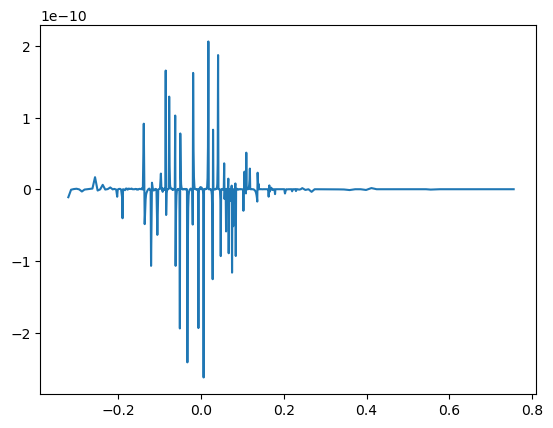

In [118]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq

def d1(df, sigma_col):
    return (np.log(df['S'] / df['K']) + (df['r'] - df['q'] + 0.5 * df[sigma_col] ** 2) * df['T']) / (df[sigma_col] * np.sqrt(df['T']))

def d2(df, sigma_col):
    return d1(df, sigma_col) - df[sigma_col] * np.sqrt(df['T'])

def add_bs_call(df: pd.DataFrame, sigma_col: str) -> pd.DataFrame:
    temp = df.copy()
    d1_vals = d1(df, sigma_col)
    d2_vals = d2(df, sigma_col)
    temp[f'bs_call_{sigma_col}'] = df['S'] * np.exp(-df['q'] * df['T']) * norm.cdf(d1_vals) - df['K'] * np.exp(-df['r'] * df['T']) * norm.cdf(d2_vals)
    return temp

def add_bs_put(df: pd.DataFrame, sigma_col: str) -> pd.DataFrame:
    temp = df.copy()
    d1_vals = d1(df, sigma_col)
    d2_vals = d2(df, sigma_col)
    temp[f'bs_put_{sigma_col}'] = df['K'] * np.exp(-df['r'] * df['T']) * norm.cdf(-d2_vals) - df['S'] * np.exp(-df['q'] * df['T']) * norm.cdf(-d1_vals)
    return temp

def bs_price(S, K, T, r, q, sigma, cp_flag):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if cp_flag == 'C':
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

def add_imvol_call(df, market_col):
    df_copy = df.copy()
    result_col = f'my_iv_{market_col}'
    df_copy[result_col] = np.nan

    for idx, row in df_copy.iterrows():
        market_price = row[market_col]
        S, K, T, r, q = row['S'], row['K'], row['T'], row['r'], row['q']
        price_lower_bound = bs_price(S, K, T, r, q, 1e-8, 'C')
        if market_price < price_lower_bound:
            continue
        func = lambda sigma: bs_price(S, K, T, r, q, sigma, 'C') - market_price
        try:
            iv = brentq(func, 1e-8, 5.0, maxiter=1000)
            df_copy.at[idx, result_col] = iv
        except Exception as e:
            print(f'brentq has failed for idx {idx}: {e}')
    
    return df_copy

def add_imvol_put(df, market_col):
    df_copy = df.copy()
    result_col = f'my_iv_{market_col}'
    df_copy[result_col] = np.nan

    for idx, row in df_copy.iterrows():
        market_price = row[market_col]
        S, K, T, r, q = row['S'], row['K'], row['T'], row['r'], row['q']
        price_lower_bound = bs_price(S, K, T, r, q, 1e-8, 'P')
        if market_price < price_lower_bound:
            continue
        func = lambda sigma: bs_price(S, K, T, r, q, sigma, 'P') - market_price
        try:
            iv = brentq(func, 1e-8, 5.0, maxiter=1000)
            df_copy.at[idx, result_col] = iv
        except Exception as e:
            print(f'brentq has failed for idx {idx}: {e}')
    
    return df_copy

df = add_imvol_call(call_df, market_col='mid')
# .loc[:, ['M', 'mid', 'bid', 'true', 'iv_mid', 'my_iv_mid', 'theta_mid']]
df = add_bs_call(df, 'my_iv_mid')
plt.plot(df['x'], df['bs_call_my_iv_mid'] - df['mid'])
# plt.plot(df['M'], (df['my_iv_mid'] - df['iv_mid']))


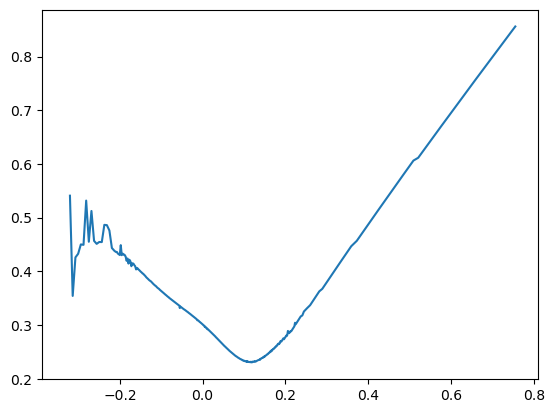

In [110]:
plt.plot(df['x'], df['my_iv_mid'])

In [39]:
call_df[['r', 'q', 'T', 'S', 'K', 'theo_iv']]

,r,q,T,S,K,theo_iv
0,0.045492,0.018461,0.067742,5158.2,200,1.463925
1,0.045492,0.018461,0.067742,5158.2,400,1.345500
2,0.045492,0.018461,0.067742,5158.2,600,1.271121
3,0.045492,0.018461,0.067742,5158.2,800,1.215591
4,0.045492,0.018461,0.067742,5158.2,1000,1.170707
...,...,...,...,...,...,...
494,0.045480,0.018461,0.067742,5158.2,10000,0.447003
495,0.045480,0.018461,0.067742,5158.2,10400,0.454565
496,0.045480,0.018461,0.067742,5158.2,10800,0.461450
497,0.045480,0.018461,0.067742,5158.2,10900,0.463094


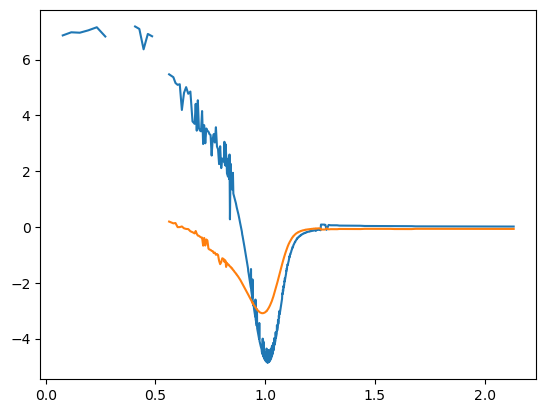

In [71]:
import matplotlib.pyplot as plt
df = add_bs_call(call_df, sigma_col='iv_mid').loc[:, ['M', 'bs_call_iv_mid', 'mid', 'theta_mid']]
plt.plot(df['M'], (df['bs_call_iv_mid'] - df['mid']))
plt.plot(df['M'], df['theta_mid'])